In [1]:
import sys
sys.path = ['',
 '/cm/shared/sw/pkg-old/devel/python2/2.7.13/bin',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python27.zip',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/plat-linux2',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-tk',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-old',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-dynload',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages/IPython/extensions',
 '/mnt/home/llevasseur/.ipython']

import warnings; warnings.simplefilter('ignore')
import tensorflow as tf
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.io
#import h5py
from skimage.transform import resize

# import matplotlib.pyplot as plt
%matplotlib inline  
from IPython import display
import pylab as pl

In [2]:
tf.enable_eager_execution()

In [9]:
execfile("AE_RIM_definitions.py")

In [4]:
batch_size = 50

npix_side = 512
input_filename = '/mnt/home/yhezaveh/_Censai_local/data/KAP_001_normalized.mat'

mat_contents = scipy.io.loadmat(input_filename)
kappa = mat_contents['KAP']

kappa = np.moveaxis( kappa , 0 , 2)
kappa = resize(kappa, (npix_side,npix_side), order=1, preserve_range=True)
kappa = np.moveaxis( kappa , 2 , 0)

In [5]:
VAE_obj = VAE(n_latent = 64 , npix_side = npix_side)

In [6]:
checkpoint_path = "checkpoints/model_VAE_512"
RESTORE = True
if (RESTORE==True):
    VAE_obj.load_weights(checkpoint_path)

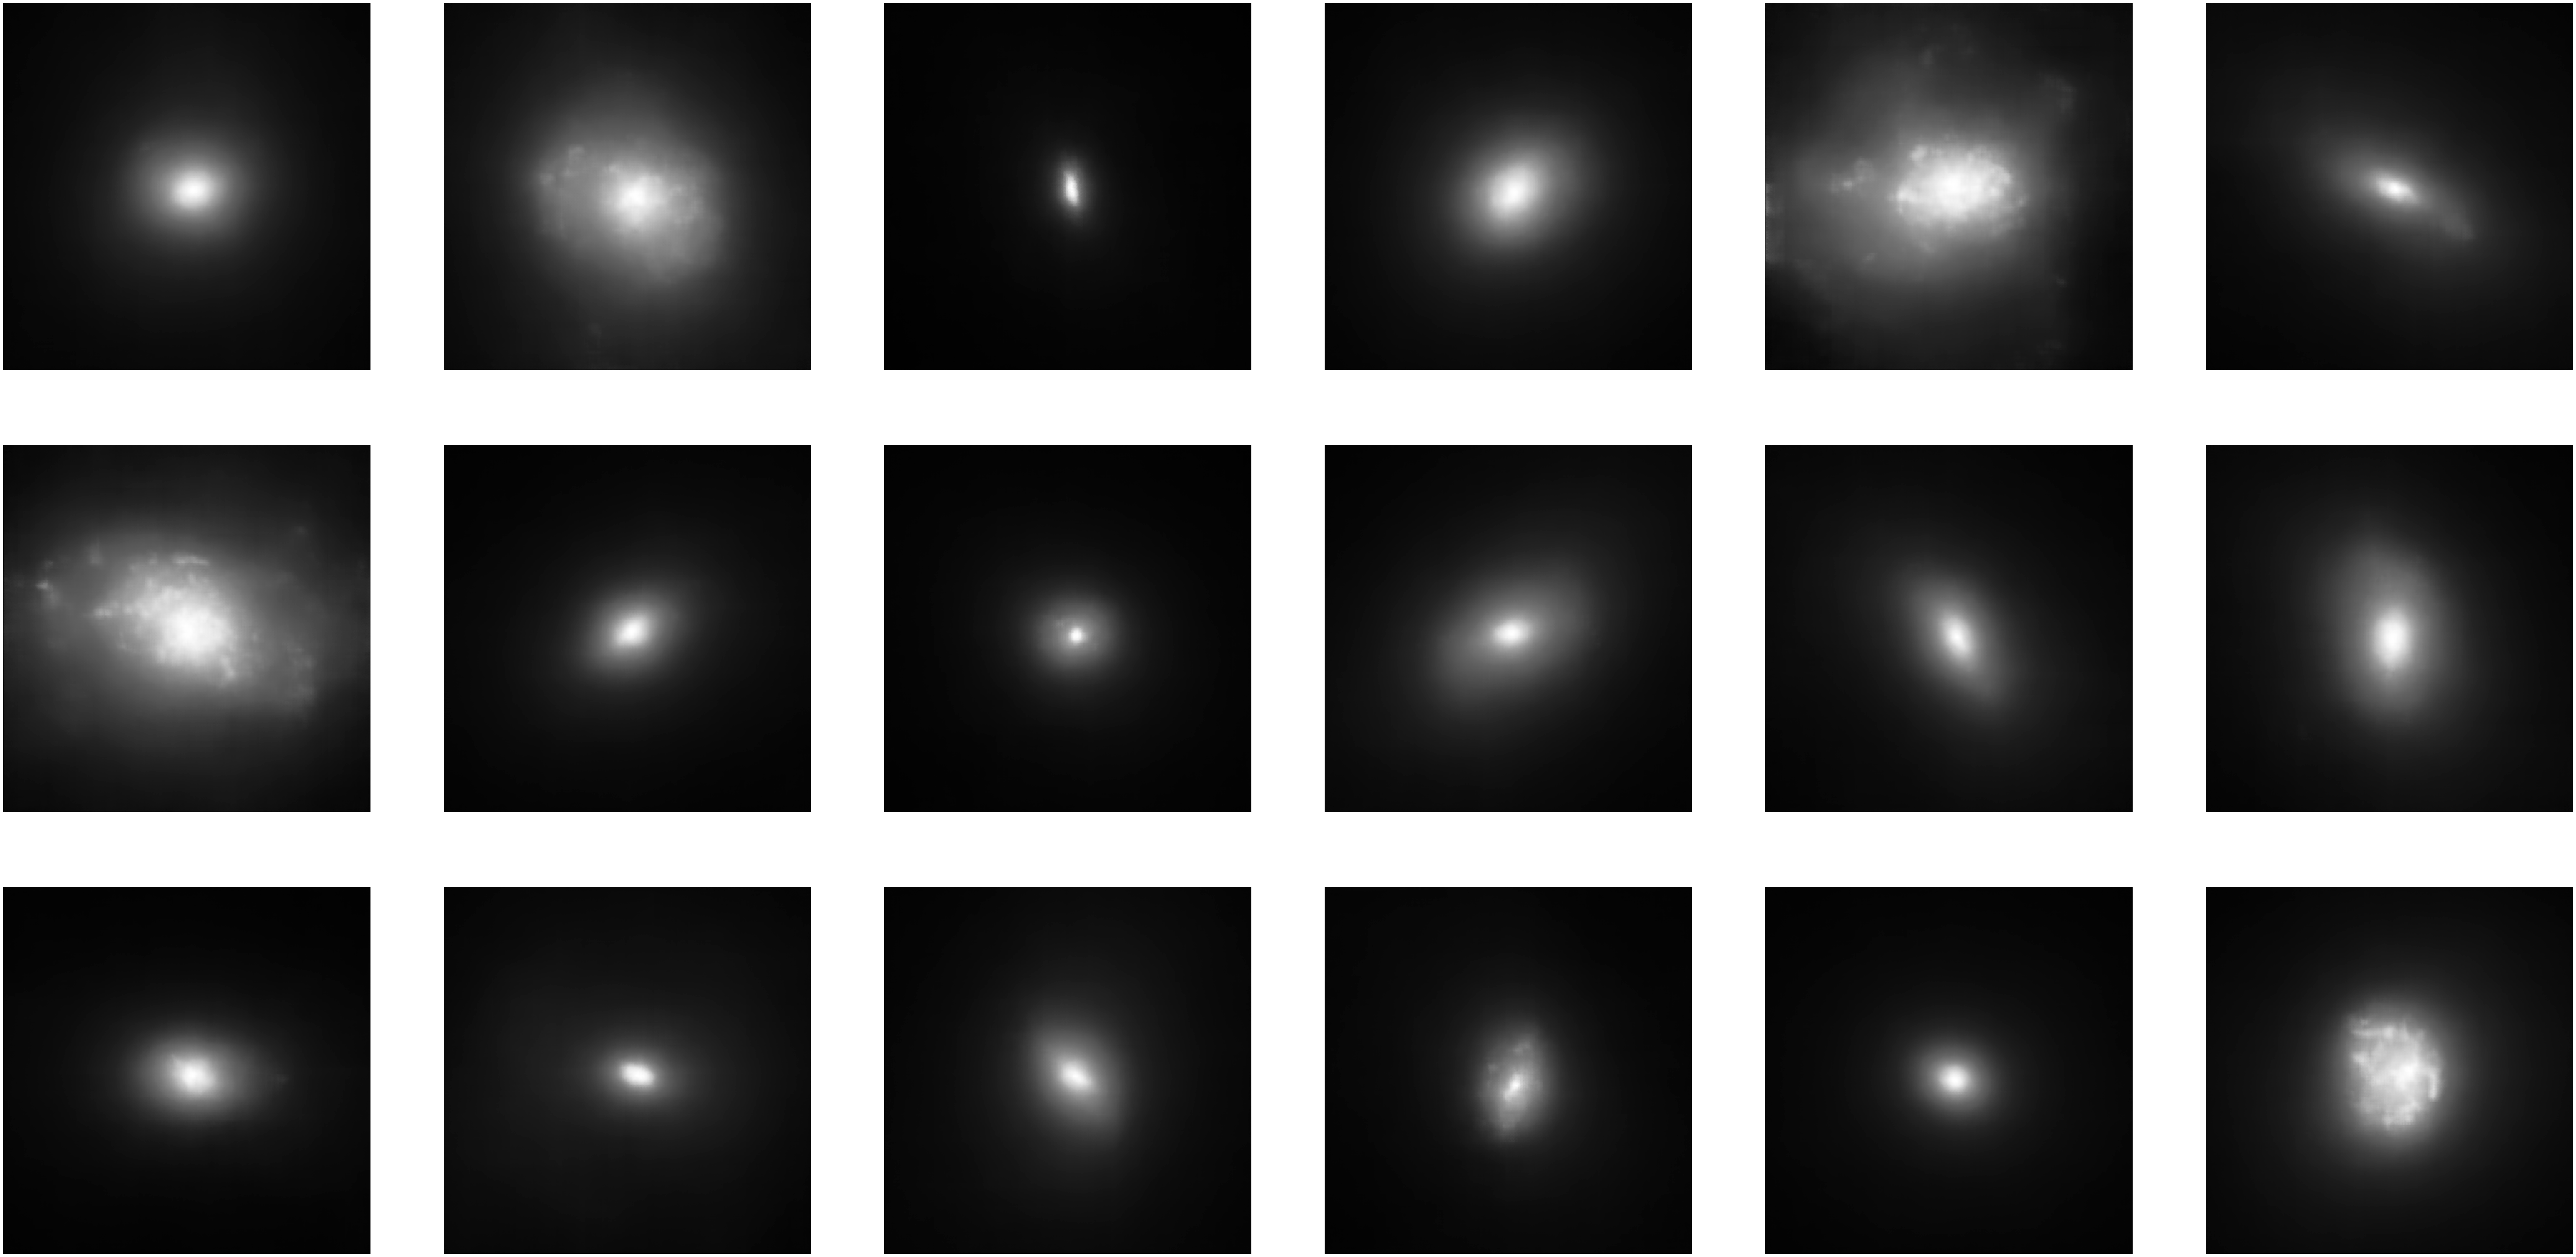

In [42]:
with tf.device('/gpu:0'):
    ims = VAE_obj.draw_image(18)
    fig = plot(ims)
    #plt.savefig('out_conv/{}.png'.format(str(im_i).zfill(3)), bbox_inches='tight')
    #plt.close(fig)



In [26]:
def plot(samples):
    fig = plt.figure(figsize=(26*6, 26*3))
    gs = gridspec.GridSpec(3, 6)
    gs.update(wspace=None, hspace=None)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample, cmap='Greys_r')
        #plt.title(str(np.max(sample)))
    return fig



In [33]:
fig = plot(ims[0:18])
plt.savefig('FIG2.png', bbox_inches='tight')
plt.close(fig)

In [8]:
optimizer = tf.train.AdamOptimizer(4e-5)

In [10]:
im_i = 0
with tf.device('/gpu:0'):
    for train_iter in range(10000000):

        ind = np.random.randint(0, high=1500, size=batch_size)
        batch_kappa = kappa[ind,:].reshape((-1,npix_side,npix_side))
        batch_kappa = tf.cast( batch_kappa , datatype)

        with tf.GradientTape() as tape:
            tape.watch(VAE_obj.variables)
            cost_value , decoded_im = VAE_obj.cost(batch_kappa)
        weight_grads = tape.gradient(cost_value, [VAE_obj.variables] )

        clipped_grads = [tf.clip_by_value(grads_i,-10,10) for grads_i in weight_grads[0]]
        optimizer.apply_gradients(zip(clipped_grads, VAE_obj.variables), global_step=tf.train.get_or_create_global_step())

        if (((train_iter+1)%50)==0):
            im_i = im_i + 1
            print( "saving weights." )
            VAE_obj.save_weights(checkpoint_path)
            print( "done." )
            ims = VAE_obj.draw_image(16)
            ims = [np.reshape(ims[i].numpy(), [npix_side, npix_side]) for i in range(16)] + [np.reshape(decoded_im[i,:,:], [npix_side, npix_side]) for i in range(16)] + [np.reshape(batch_kappa[i,:,:], [npix_side, npix_side]) for i in range(16)]
            pl.clf()
            fig = plot(ims)
            display.clear_output(wait=True)
            display.display(pl.gcf())

